In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
EPOCHS =3
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((100,100))
#image_size = 0
width=100
height=100
depth=3
train_dir=r"C:\Users\Glau\Desktop\Pedistrum\Augment\Train"
valid_dir=r"C:\Users\Glau\Desktop\Pedistrum\Augment\Test"
train_folder=listdir(train_dir)
valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Lacunastrum gracilimum ...
processing Monactinus simplex ...
processing Parapediastrum biradiatum ...
processing Pediastrum angulosum ...
[INFO] Image loading completed


In [6]:
print(len(train_image_label))

9600


In [7]:
valid_image_list, valid_image_label= [], []
for disease_folder in valid_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{valid_dir}/{disease_folder}")
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]: 
        image_directory = f"{valid_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            valid_image_list.append(convert_image_to_array(image_directory))
            valid_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Lacunastrum gracilimum ...
processing Monactinus simplex ...
processing Parapediastrum biradiatum ...
processing Pediastrum angulosum ...
[INFO] Image loading completed


In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_marine_alex_con.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0
np_valid_image_list = np.array(valid_image_list, dtype=np.float32) / 255.0

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [20]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

_input = Input((100,100,3)) 

conv1  = Conv2D(filters=64, kernel_size=(7,7), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(4, activation="softmax")(dense1)


model  = Model(inputs=_input, outputs=output)

In [21]:
model.compile(optimizer=RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 100
img_width = 100
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 256)  19456       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 256)  1024        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 50, 50, 256)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv2d_336 (Conv2D)             (None, 7, 7, 8)      584         lambda_313[0][0]                 
__________________________________________________________________________________________________
conv2d_337 (Conv2D)             (None, 7, 7, 8)      584         lambda_314[0][0]                 
__________________________________________________________________________________________________
conv2d_338 (Conv2D)             (None, 7, 7, 8)      584         lambda_315[0][0]                 
__________________________________________________________________________________________________
conv2d_339 (Conv2D)             (None, 7, 7, 8)      584         lambda_316[0][0]                 
__________________________________________________________________________________________________
conv2d_340 (Conv2D)             (None, 7, 7, 8)      584         lambda_317[0][0]                 
__________________________________________________________________________________________________
conv2d_341

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [23]:
history=model.fit(np_train_image_list,bin_train_image_labels,
                  validation_data=(np_valid_image_list, bin_valid_image_labels),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )

Train on 9600 samples, validate on 2400 samples
Epoch 1/3
9600/9600 [==============================] - 27s 3ms/step - loss: 0.3399 - accuracy: 0.8535 - val_loss: 0.2002 - val_accuracy: 0.9546
Epoch 2/3
9600/9600 [==============================] - 27s 3ms/step - loss: 0.1903 - accuracy: 0.9306 - val_loss: 0.0699 - val_accuracy: 0.9787
Epoch 3/3
9600/9600 [==============================] - 27s 3ms/step - loss: 0.0848 - accuracy: 0.9759 - val_loss: 0.0184 - val_accuracy: 0.9954


In [24]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
2400/2400 [==============================] - 2s 901us/step
Test Accuracy: 99.54166412353516


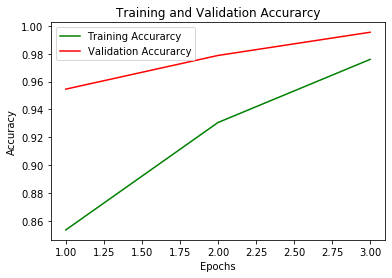

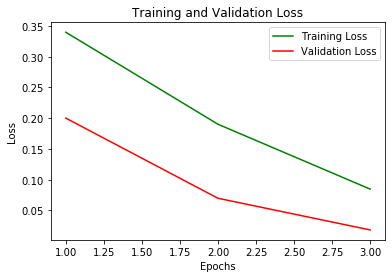

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
ycalculated = model.predict(np_valid_image_list)

In [27]:
yhat_classes =np.argmax(ycalculated,axis=1)

In [28]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)

In [29]:
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
#import seaborn as sns
#y_pred=model.predict_classes(np_valid_image_list)
#con_mat = tf.math.confusion_matrix(labels=y_true, predictions=ycalculated).numpy()
#matrix = confusion_matrix(rounded_labels,yhat_classes)
#y_pred=model.predict(np.array(val_image_list))
#yhat_classes = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#rounded_labels = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
cm =confusion_matrix(rounded_labels,yhat_classes)  

#matrix =confusion_matrix(bin_val_image_labels.argmax(axis=1), ycalculated)
print(cm)

[[600   0   0   0]
 [ 11 589   0   0]
 [  0   0 600   0]
 [  0   0   0 600]]


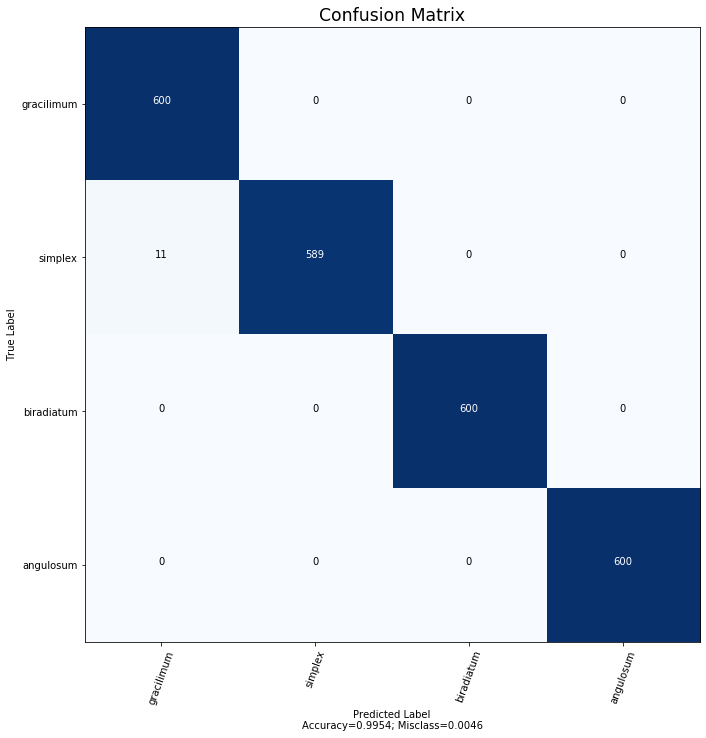

In [30]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=70)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm, 
                      normalize = False,
                      target_names=['gracilimum','simplex','biradiatum','angulosum'],
                      title        = "Confusion Matrix")

In [31]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['gracilimum','simplex','biradiatum','angulosum']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))


              precision    recall  f1-score   support

  gracilimum       0.98      1.00      0.99       600
     simplex       1.00      0.98      0.99       600
  biradiatum       1.00      1.00      1.00       600
   angulosum       1.00      1.00      1.00       600

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

